In [131]:
import pandas as pd
import numpy as np
import math 
import random

In [132]:
def bfs(adjList, start=[], l = math.inf):
    visited, queue = set(), start
    while queue:
        vertex = queue.pop(0)
        if(len(visited) < l):
          if vertex not in visited:
            visited.add(vertex)
            queue.extend(set(i['to'] for i in adjList[vertex]) - visited)
    return visited

## **Импорт данных**

In [133]:
from itertools import takewhile
filepath = './datasets/'
dataset = 'bitcoinotc.csv'
headers = ['From',"To", 'weight', 'timestamp']
testHeaders = ['From', 'To']
with open(filepath + dataset) as f:
  skip_rows = len(list(
      takewhile(lambda s: s.startswith("%"), f)
  ))

df = pd.read_csv(filepath + dataset, names=headers, skiprows=skip_rows, index_col=False, delimiter=r'\s+')\
.drop(columns=["weight"])\
.sort_values(by="timestamp")

# **Характеристики графа:**

## **Число вершин**

In [134]:
V_num = pd.unique(df[['From', 'To']].values.ravel()).size
print(V_num)

5881


## **Число рёбер**

In [135]:
adjList = [[] for _ in range(V_num + 1)]
E_num = 0 # количество ребер
for line in df.itertuples():
  [From, To, time] = [line.From, line.To, line.timestamp]
  if From != To and To not in [i['to'] for i in adjList[From]]: 
    adjList[From].append({'to' : To, 'time': time})
    adjList[To].append({'to' : From, 'time': time})
    E_num += 1
print(E_num)

21492


## **Плотность**

In [136]:
density = E_num / (V_num*(V_num - 1) / 2)
print(density)

0.001243020588612932


## **Статистика по КСС**

In [137]:
Vertexes = set(range(1, V_num))
count = 0
max_size = 0
max_WCC = set()

while len(Vertexes) > 0:
  WCC = bfs(adjList ,[Vertexes.pop()])
  size = len(WCC)
  if size > max_size:
    max_size = size
    max_WCC = WCC
  count += 1
  Vertexes -= WCC

print("Количество компонент слабой связности: ", count)
print("Наибольшая КСС: ", max_WCC)
print("Мощность наибольшей КСС: ", max_size)
print("Отношение мощности наибольшей КСС к общему количеству вершин: ", max_size / V_num)


Количество компонент слабой связности:  4
Наибольшая КСС:  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210

## **Средний кластерный коэффициент**

In [138]:
def local_clustering_coefficient(adjList, u):
    #print("u =", u, end=": ")

    # сет соседей вершины u
    adj2u_set = set()
    for v_tuple in adjList[u]:
        to = v_tuple['to']
        adj2u_set.add(to)

    gamma_u = len(adj2u_set)
    #print("length of adj2u =", gamma_u, end=", ")
    if (gamma_u < 2):
        #print("Only one adj node => Return 0")
        return 0

    L_u = countEdgesInSet(adjList, adj2u_set)

    #print("L_u =", L_u, end=", ")

    Cl_u = 2 * L_u / (gamma_u * (gamma_u - 1))

    #print("Cl_u =", Cl_u)

    return Cl_u

# считает количество ребер между вершинами в сете
def countEdgesInSet(adjList, vertexes_set):
    sum = 0
    for node in vertexes_set:
        for neighbour_node in adjList[node]:
            to = neighbour_node['to'] # neighbour_node - это tuple(to, time)
            if to in vertexes_set:
                sum+=1
    return sum // 2

sum_Cl = 0
for vertex in max_WCC:
    sum_Cl+=local_clustering_coefficient(adjList, vertex)

average_Cl = sum_Cl / len(max_WCC)

print("Средний кластерный коэффициент для наибольшей КСС:", average_Cl)

Средний кластерный коэффициент для наибольшей КСС: 0.17768577523831092


## **Коэффициент корреляции Пирсона**

In [139]:
from statistics import mean

def pearson_correlation(adjList):
  X = []
  Y = []

  for i in range(1, len(adjList)):
    for j in adjList[i]:
      X.append(len(adjList[i]))
      Y.append(len(adjList[j['to']]))

  avgX = mean(X)
  avgY = mean(Y)

  XminusAvgX = [i - avgX for i in X]
  YminusAvgY = [i - avgY for i in Y]

  Z = [i*j for i,j in zip(XminusAvgX, YminusAvgY)]

  XminusAvgX_sq = [i**2 for i in XminusAvgX]
  YminusAvgY_sq = [i**2 for i in YminusAvgY]

  amounts = [sum(Z), sum(XminusAvgX_sq), sum(YminusAvgY_sq)]

  return amounts[0]/((amounts[1]*amounts[2])**0.5)

PC = pearson_correlation(adjList)

print("pearson_correlation:", PC)

pearson_correlation: -0.16483359451313628


## **Вычисление диаметра, радиуса, расстояний, 90-го персентиля**

In [140]:
def Perc(l, p):
  l.sort()
  if p < 100:
    return l[math.floor(len(l) * p / 100)]
  elif p == 100:
    return l[-1]
  return -1

#алгоритм Флойда-Уоршелла
def floyd_warshall(adjMat):
  n = len(adjMat)
  for k in range(n):
    for i in range(n):
      for j in range(n):
        adjMat[i][j] = min(adjMat[i][j], adjMat[i][k] + adjMat[k][j]);
  return adjMat

def calcRadDimPerc(disM):
  rad = math.inf
  dim = 0
  dist = []
  n = len(disM)
#Диаметр и радиус
  for i in range(n):
    max = 0
    for j in range(n):
      if disM[i][j] != math.inf:
        if disM[i][j] > max:
          max = disM[i][j]
        dist.append(disM[i][j])
    if max != 0:
      if max < rad:
        rad = max
      if max > dim:
        dim = max
  perc90 = Perc(dist, 90)
  return [rad, dim, perc90]

In [141]:
#Матрица для расстояний
def createAdjL(max_WCC_sort, adjList):
  n = len(max_WCC_sort)
  for i in range(n):
    max_WCC_sort[i] = [i, max_WCC_sort[i]]
  adjL = [[math.inf for i in range(n)] for _ in range(n)]
  for i, j in max_WCC_sort:
    adjL[i][i] = 0
    for k in adjList[j]:
      for p in max_WCC_sort:
        if k['to'] == p[1]:
          adjL[i][p[0]] = 1
  return adjL

## **Снефжный ком, случайные выборки**

In [142]:
def rand_sample_metrics(adjList, max_comp, size):
  if len(max_comp) > size:
    rand_sample = random.sample(max_comp, size)
  else:
    rand_sample = max_comp
  rand_sample = sorted(rand_sample)

  disM = floyd_warshall(createAdjL(rand_sample, adjList))
  return calcRadDimPerc(disM)

def snowball(adjList, max_comp, size):
  if len(max_comp) > size:
    sample = bfs(adjList, random.sample(max_comp, 3), size)
  else:
    sample = max_comp
  sample = sorted(sample)

  disM = floyd_warshall(createAdjL(sample, adjList))
  return calcRadDimPerc(disM)

In [143]:
rand_sample_500_results = rand_sample_metrics(adjList, max_WCC, 1000)
snowball_500_results = snowball(adjList, max_WCC, 1000)

<ipython-input-142-3c7dd4c13fee>:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  rand_sample = random.sample(max_comp, size)
<ipython-input-142-3c7dd4c13fee>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = bfs(adjList, random.sample(max_comp, 3), size)


## **Результаты по характеристикам**

In [144]:
print(
    f'Характеристики датасета {dataset}: \n'\
    f'Число вершин: {V_num} \n'
    f'Число рёбер: {E_num} \n'\
    f'Плотность: {density} \n'\
    f'Количество компонент слабой связности: {count} \n'\
    #f'Наибольшая КСС: {max_WCC} \n'\
    f'Мощность наибольшей КСС: {max_size} \n'\
    f'Отношение мощности наибольшей КСС к общему количеству вершин: {max_size / V_num} \n'\
    f'Средний кластерный коэффициент для наибольшей КСС: {average_Cl} \n'\
    f'Коэффициент корреляции Пирсона: {PC} \n'\
    f'Диаметр(random_sample_500): {rand_sample_500_results[1]} \n'\
    f'Радиус(random_sample_500): {rand_sample_500_results[0]} \n'\
    f'90-й персентиль(random_sample_500): {rand_sample_500_results[2]} \n'\
    f'Диаметр(snowball_sample_500): {snowball_500_results[1]} \n'\
    f'Радиус(snowball_500): {snowball_500_results[0]} \n'\
    f'90-й персентиль(snowball_500): {snowball_500_results[2]} \n'\
)

Характеристики датасета bitcoinotc.csv: 
Число вершин: 5881 
Число рёбер: 21492 
Плотность: 0.001243020588612932 
Количество компонент слабой связности: 4 
Мощность наибольшей КСС: 5875 
Отношение мощности наибольшей КСС к общему количеству вершин: 0.9989797653460296 
Средний кластерный коэффициент для наибольшей КСС: 0.17768577523831092 
Коэффициент корреляции Пирсона: -0.16483359451313628 
Диаметр(random_sample_500): 12 
Радиус(random_sample_500): 1 
90-й персентиль(random_sample_500): 6 
Диаметр(snowball_sample_500): 6 
Радиус(snowball_500): 3 
90-й персентиль(snowball_500): 3 



# **Статические признаки**

In [145]:
# Common Neighbours (CN) - количество общих соседей у двух вершин
def common_neighbours(adjList, u, v):
    set_u = set(i['to'] for i in adjList[u])
    set_v = set(i['to'] for i in adjList[v])
    return len(set_u.intersection(set_v))

# Adamic-Adar (AA) - сумма обратных логарифмов степеней общих соседей
def adamic_adar(adjList, u, v):
    set_u = set(i['to'] for i in adjList[u])
    set_v = set(i['to'] for i in adjList[v])
    common = set_u.intersection(set_v)
    aa = 0
    for c in common:
        degree = len(adjList[c])
        if degree > 1:
            aa += 1 / math.log(degree)
    return aa

# Jaccard Coefficient (JC) - отношение числа общих соседей к числу уникальных соседей
def jaccard_coefficient(adjList, u, v):
    set_u = set(i['to'] for i in adjList[u])
    set_v = set(i['to'] for i in adjList[v])
    intersection = set_u.intersection(set_v)
    union = set_u.union(set_v)
    if len(union) == 0:
        return 0
    return len(intersection) / len(union)

# Preferential Attachment (PA) - произведение степеней двух вершин
def preferential_attachment(adjList, u, v):
    return len(adjList[u]) * len(adjList[v])



def get_static_feat(adjList, u, v):
  return [common_neighbours(adjList, u, v), adamic_adar(adjList, u, v), jaccard_coefficient(adjList, u, v), preferential_attachment(adjList, u, v)]



In [146]:
print(get_static_feat(adjList, 1,2))

[10, 2.523938713752512, 0.10204081632653061, 2915]


In [147]:
# Создаем пустой словарь для хранения признаков для каждой пары вершин
features = {}

# Итерируемся по всем парам вершин в наибольшей КСС
for u in max_WCC:
    for v in max_WCC:
        if u != v:
            # Проверяем, что еще не вычисляли признаки для этой пары вершин
            if (u, v) not in features and (v, u) not in features:
                # Считаем признаки для пары вершин
                cn = common_neighbours(adjList, u, v)
                aa = adamic_adar(adjList, u, v)
                jc = jaccard_coefficient(adjList, u, v)
                pa = preferential_attachment(adjList, u, v)
                # Сохраняем результаты в словаре
                features[(u, v)] = {'CN': cn, 'AA': aa, 'JC': jc, 'PA': pa}
    
# Выводим признаки для первых 10 пар вершин в словаре
for pair, feature in list(features.items())[:10]:
    print(pair, feature)

# на случайной паре вершин
n = random.randint(5, len(max_WCC))
randVertexes = random.sample(max_WCC, n)
u = random.choice(randVertexes)
v = random.choice(randVertexes)
print("u =", 2)
print("v =", 1)
print("CN =", common_neighbours(adjList, u, v))
print("AA =", adamic_adar(adjList, u, v))
print("JC =", jaccard_coefficient(adjList, u, v))
print("PA =", preferential_attachment(adjList, u, v))

(1, 2) {'CN': 10, 'AA': 2.523938713752512, 'JC': 0.10204081632653061, 'PA': 2915}
(1, 3) {'CN': 2, 'AA': 0.3619412558371284, 'JC': 0.03571428571428571, 'PA': 165}
(1, 4) {'CN': 31, 'AA': 8.868062043669992, 'JC': 0.1076388888888889, 'PA': 14520}
(1, 5) {'CN': 4, 'AA': 0.9764167931084915, 'JC': 0.058823529411764705, 'PA': 935}
(1, 6) {'CN': 11, 'AA': 2.3407138502671905, 'JC': 0.09821428571428571, 'PA': 3740}
(1, 7) {'CN': 6, 'AA': 1.491962865256243, 'JC': 0.08571428571428572, 'PA': 1155}
(1, 8) {'CN': 17, 'AA': 3.8401150644120854, 'JC': 0.06719367588932806, 'PA': 11825}
(1, 9) {'CN': 1, 'AA': 0.18619761651459218, 'JC': 0.01818181818181818, 'PA': 55}
(1, 10) {'CN': 3, 'AA': 0.6174099309633001, 'JC': 0.04918032786885246, 'PA': 495}
(1, 11) {'CN': 18, 'AA': 4.776004984757343, 'JC': 0.06521739130434782, 'PA': 13145}
u = 2
v = 1
CN = 0
AA = 0
JC = 0.0
PA = 3


<ipython-input-147-b713fd1ce712>:24: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  randVertexes = random.sample(max_WCC, n)


## **Определения функций для temporal features**

### **Temporal weighting**

In [148]:
l = 0.2
t_min = df['timestamp'].min()
t_max = df['timestamp'].max()
delta_t = t_min + (t_max - t_min) * 0.66

def get_sub_f(t):
  return (t - t_min) / delta_t

def get_w_lin(l, t):
  sub_f = get_sub_f(t)
  return l + (1 - l) * sub_f

def get_w_exp(l, t):
  sub_f = get_sub_f(t)
  return l + (1 - l) * (math.exp(-3 * sub_f) - 1) / (math.pow(math.e, -3) - 1)

def get_w_sqrt(l, t):
  sub_f = get_sub_f(t)
  return l + (1 - l) * math.sqrt(sub_f) 

### **Node activity**

In [149]:
def get_zeroth(w):
  return Perc(w, 0)

def get_first(w):
  return Perc(w, 25)

def get_second(w):
  return Perc(w, 50)

def get_third(w):
  return Perc(w, 75)

def get_fourth(w):
  return Perc(w, 100)

def get_sum(w):
  return sum(w)

def get_mean(w):
  return mean(w)


def agg_node_activity(w):
  return [get_zeroth(w), get_first(w), get_second(w), get_third(w), get_fourth(w), get_sum(w), get_mean(w)]

### **Combining node activity**

In [150]:
def get_sum_1(a, b):
  return a + b
  
def get_abs_diff(a, b):
  return abs(a - b)
  
def get_min(a, b):
  return min(a, b)
  
def get_max(a, b):
  return max(a, b)

def combine(a, b):
  feat = []
  for a, b in zip(a, b):
    feat.extend([get_sum_1(a, b), get_abs_diff(a, b), get_min(a, b), get_max(a, b)])
  return feat

## **Вычисления**

### **Temporal weighting**

In [151]:
f_mat = {i: dict() for i in range(V_num + 1)}

for _, fr, to, timestamp in df.itertuples():
  if fr == to or timestamp > delta_t:
      continue
  if f_mat[fr].get(to): 
      f_mat[fr][to].append(timestamp)
  else:
      f_mat[fr][to] = [timestamp]
  
  if f_mat[to].get(fr): 
      f_mat[to][fr].append(timestamp)
  else:
      f_mat[to][fr] = [timestamp]

### **Node activity**

In [152]:
def get_temporal_feat(l, t):
  return [get_w_lin(l, t), get_w_exp(l, t), get_w_sqrt(l, t)]

for x in f_mat.values():
  for to, times in x.items():
    for i, t in enumerate(times):
      x[to][i] = get_temporal_feat(l, t)

In [153]:
node_activity = {i: list() for i in range(V_num + 1)}

for fr, feat in f_mat.items():
  if len(feat) == 0:
    continue
  lin = []
  exp = []
  squar = []
  for to, fw in feat.items():
    lin.extend([w[0] for w in fw])
    exp.extend([w[1] for w in fw])
    squar.extend([w[2] for w in fw])
  for w in (lin, exp, squar):
    node_activity[fr].extend(agg_node_activity(w))

## **Ищем пары и вычисляем характеристики**

In [154]:
pairs = set()
for u in range(V_num + 1):
    u_adj = set(f_mat[u].keys())
    for v in range(u + 1, V_num + 1):
        v_adj = set(f_mat[v].keys())
        if u not in f_mat[v].keys() and u_adj.intersection(v_adj):
          pairs.add((u, v))

In [155]:
con_pairs = list()
non_pairs = list()

for i,j in pairs:
  if j in [k['to'] for k in adjList[i]]:
    con_pairs.append((i, j))
  else:
    non_pairs.append((i, j))

In [156]:
sample_size = 10000

x_t = random.choices(con_pairs, k=sample_size)
x_n = random.choices(non_pairs, k=sample_size)

x = list(x_t)
x.extend(x_n)
y = [1]*sample_size
y.extend([0]*sample_size)


In [157]:
static_feat = dict.fromkeys(x)
temp_feat = dict.fromkeys(x)

for u, v in static_feat.keys():
  static_feat[(u, v)] = get_static_feat(adjList, u, v)
  temp_feat[(u, v)] = combine(node_activity[u], node_activity[v])

# **Бинарная классификация**

In [158]:
from sklearn.model_selection import train_test_split

In [159]:
static_x = []
temp_x = []
for i in x:
  static_x.append(static_feat[i])
  temp_x.append(temp_feat[i])

x_static_train, x_static_test, y_static_train_labels, y_static_test_labels = train_test_split(static_x, y, test_size=0.25, random_state=42)
x_temp_train, x_temp_test, y_temp_train_labels, y_temp_test_labels = train_test_split(temp_x, y, test_size=0.25, random_state=42)

In [160]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, roc_curve, classification_report, confusion_matrix, auc
from matplotlib import pyplot as plt

In [161]:
static_model = LogisticRegression(max_iter=10000)
static_model.fit(x_static_train, y_static_train_labels)
y_pred_static = static_model.predict(x_static_test)
y_pred_static_proba = static_model.predict_proba(x_static_test)
print(classification_report(y_static_test_labels, y_pred_static))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2476
           1       0.96      0.88      0.92      2524

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



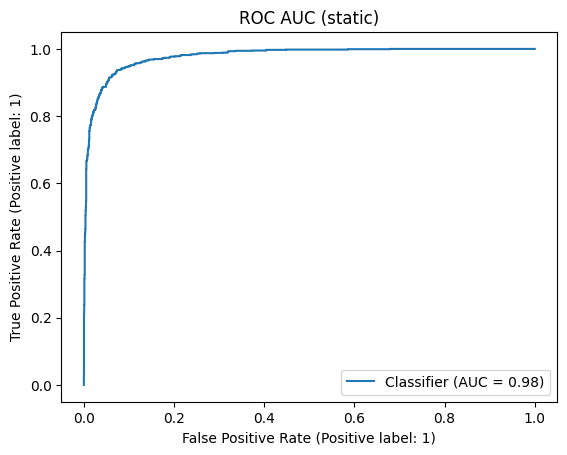

In [162]:
RocCurveDisplay.from_predictions(y_static_test_labels, y_pred_static_proba[:, 1])
plt.title("ROC AUC (static)")
plt.show()

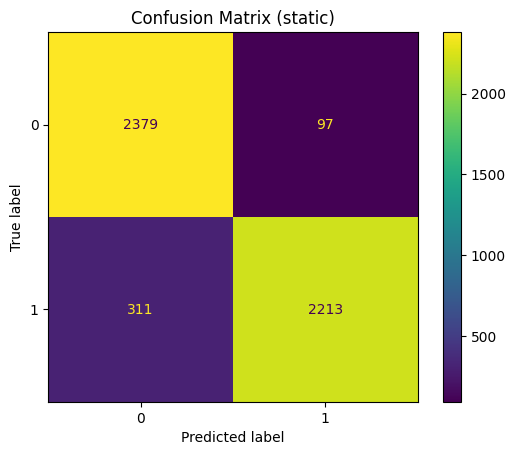

In [163]:
cm_static = confusion_matrix(y_static_test_labels, y_pred_static, labels=static_model.classes_)
disp_t = ConfusionMatrixDisplay(confusion_matrix=cm_static, display_labels=static_model.classes_)
disp_t.plot()
disp_t.ax_.set_title('Confusion Matrix (static)')
plt.show()

In [164]:
temp_model = LogisticRegression(max_iter=10000)
temp_model.fit(x_temp_train, y_temp_train_labels)
y_pred_temp = temp_model.predict(x_temp_test)
y_pred_temp_proba = temp_model.predict_proba(x_temp_test)
print(classification_report(y_temp_test_labels, y_pred_temp))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      2476
           1       0.91      0.93      0.92      2524

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



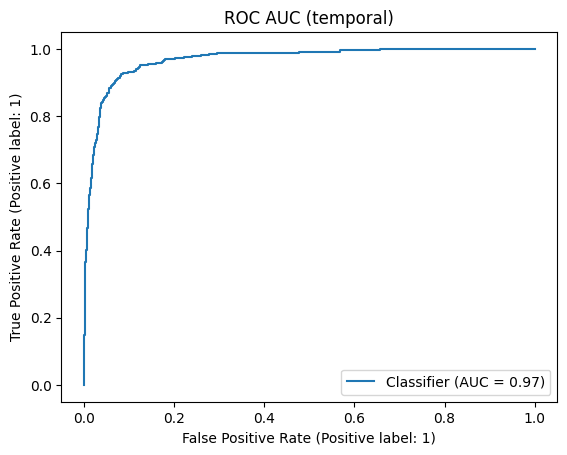

In [165]:
RocCurveDisplay.from_predictions(y_temp_test_labels, y_pred_temp_proba[:, 1])
plt.title("ROC AUC (temporal)")
plt.show()

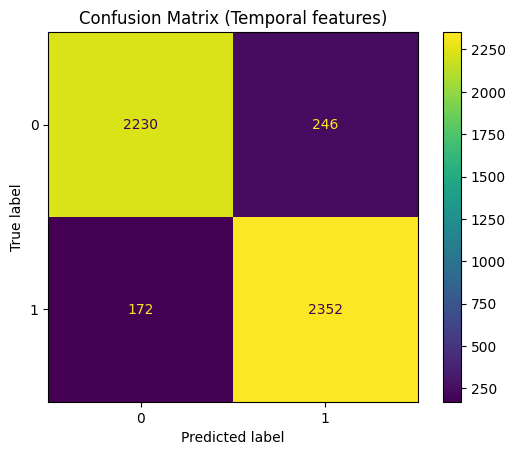

In [166]:
cm_temp = confusion_matrix(y_temp_test_labels, y_pred_temp, labels=temp_model.classes_)
disp_t = ConfusionMatrixDisplay(confusion_matrix=cm_temp, display_labels=temp_model.classes_)
disp_t.plot()
disp_t.ax_.set_title('Confusion Matrix (Temporal features)')
plt.show()